In [ ]:
!nvidia-smi

Thu Sep 22 11:34:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
od.download(r'https://www.kaggle.com/datasets/arunrk7/surface-crack-detection')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: adarshshailendra
Your Kaggle Key: ··········


100%|██████████| 233M/233M [00:01<00:00, 174MB/s]


In [ ]:
from pathlib import Path as pt
negative_dir = pt(r'/content/surface-crack-detection/Negative')
positive_dir = pt(r'/content/surface-crack-detection/Positive')

In [ ]:
import pandas as pd
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [ ]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df.head()

,Filepath,Label
0,/content/surface-crack-detection/Positive/0696...,POSITIVE
1,/content/surface-crack-detection/Positive/0986...,POSITIVE
2,/content/surface-crack-detection/Positive/1428...,POSITIVE
3,/content/surface-crack-detection/Negative/0173...,NEGATIVE
4,/content/surface-crack-detection/Positive/0144...,POSITIVE


In [ ]:
df = all_df.sample(frac = 1).reset_index(drop = True)
df.head()

,Filepath,Label
0,/content/surface-crack-detection/Positive/1098...,POSITIVE
1,/content/surface-crack-detection/Negative/1222...,NEGATIVE
2,/content/surface-crack-detection/Positive/0736...,POSITIVE
3,/content/surface-crack-detection/Positive/1555...,POSITIVE
4,/content/surface-crack-detection/Negative/0700...,NEGATIVE


In [ ]:
df.shape

(40000, 2)

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function = tf.keras.applications.resnet.preprocess_input
)

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    df.sample(40000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

In [ ]:
train_data = image_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = image_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = image_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


In [ ]:
model = tf.keras.models.Sequential()

resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='avg'
)
for layer in resnet.layers:
        layer.trainable=False
model.add(resnet)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 27,782,273
Trainable params: 4,194,561
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
def train_gpu():
  with tf.device('/device:GPU:0'):
    history = model.fit(train_data,validation_data=val_data,epochs=50, callbacks = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience=5))
    return history

In [ ]:
history = train_gpu()

Epoch 1/50
105/105 [==============================] - 22s 83ms/step - loss: 0.2839 - accuracy: 0.9086 - val_loss: 0.1604 - val_accuracy: 0.9690
Epoch 2/50
105/105 [==============================] - 8s 80ms/step - loss: 0.1151 - accuracy: 0.9670 - val_loss: 0.1175 - val_accuracy: 0.9714
Epoch 3/50
105/105 [==============================] - 9s 84ms/step - loss: 0.1000 - accuracy: 0.9688 - val_loss: 0.0951 - val_accuracy: 0.9655
Epoch 4/50
105/105 [==============================] - 8s 72ms/step - loss: 0.0981 - accuracy: 0.9699 - val_loss: 0.0804 - val_accuracy: 0.9679
Epoch 5/50
105/105 [==============================] - 8s 72ms/step - loss: 0.1028 - accuracy: 0.9664 - val_loss: 0.1877 - val_accuracy: 0.9357
Epoch 6/50
105/105 [==============================] - 8s 72ms/step - loss: 0.0789 - accuracy: 0.9723 - val_loss: 0.0806 - val_accuracy: 0.9690
Epoch 7/50
105/105 [==============================] - 8s 72ms/step - loss: 0.0709 - accuracy: 0.9756 - val_loss: 0.0790 - val_accuracy: 0.977

In [ ]:
type(history)

keras.callbacks.History

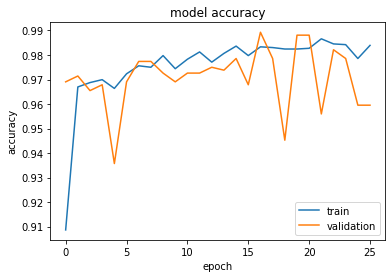

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

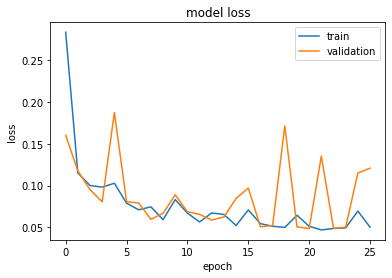

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
model.evaluate(test_data)

57/57 [==============================] - 3s 57ms/step - loss: 0.1059 - accuracy: 0.9694


[0.10592695325613022, 0.9694444537162781]

In [ ]:
test_data.class_indices

{'NEGATIVE': 0, 'POSITIVE': 1}

In [ ]:
import numpy as np
from keras.preprocessing import image
test_img = tf.keras.utils.load_img('/content/Test.jpg',
                         target_size = (120,120))
test_img = tf.keras.preprocessing.image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis = 0)
result = model.predict(test_img)
result

array([[1.]], dtype=float32)

In [ ]:
test_img = tf.keras.utils.load_img('/content/Test0.jpg',
                         target_size = (120,120))
test_img = tf.keras.preprocessing.image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis = 0)
result = model.predict(test_img)
result

array([[1.]], dtype=float32)